<a href="https://colab.research.google.com/github/Salma-Kassem/DeepLearning/blob/main/DCGANS_CELEBA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/Classroom/Img/img_align_celeba.zip'
extract_to = '/content/celeba_extracted'  # Destination directory

# Create destination directory
os.makedirs(extract_to, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete.")

Extraction complete.


In [ ]:
import tensorflow as tf

image_folder = '/content/celeba_extracted/img_align_celeba'

dataset = tf.keras.utils.image_dataset_from_directory(
    directory=image_folder,
    labels=None,                   # No labels needed for GANs
    image_size=(64, 64),           # Resize for DCGAN input (typically 64x64)
    batch_size=128,                 # Use batches
    shuffle=True
)

# Normalize to [-1, 1]
def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.0
    return (img - 0.5) / 0.5

dataset = dataset.map(preprocess)

Found 202599 files.


In [ ]:
import numpy as np

# Get one batch from the dataset
for batch in dataset.take(1):
    print("Batch shape:", batch.shape)
    print("Type:", type(batch))


Batch shape: (128, 64, 64, 3)
Type: <class 'tensorflow.python.framework.ops.EagerTensor'>


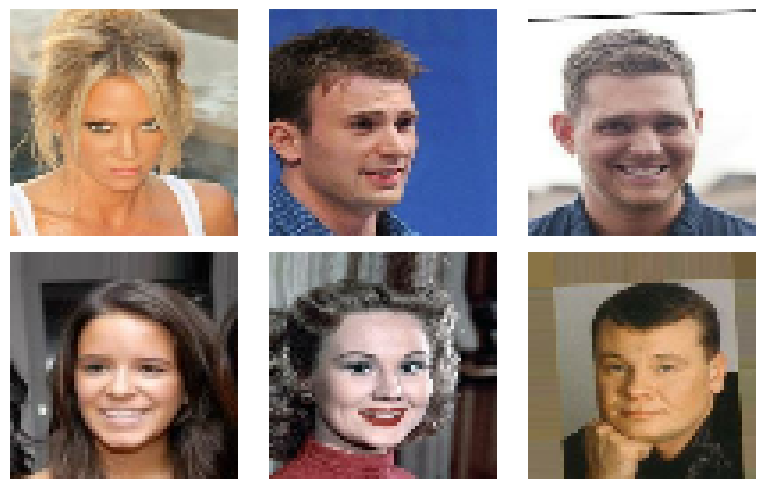

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_image_grid(images, rows=2, cols=3, figsize=(8, 5)):
    """Display a grid of images from a 4D tensor or array."""
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i in range(rows * cols):
        if i < len(images):
            img = images[i]
            img = (img * 0.5 + 0.5)  # De-normalize from [-1, 1] to [0, 1]
            axes[i].imshow(img)
            axes[i].axis('off')
        else:
            axes[i].axis('off')  # Hide unused subplots

    plt.tight_layout()
    plt.show()

# --- New Part: Iterate through the tf.data.Dataset to get one batch ---
# This assumes tf_images is a tf.data.Dataset object
for batch in dataset.take(1):  # Take one batch from the dataset
    images_np = batch.numpy()    # Convert to NumPy
    show_image_grid(images_np, rows=2, cols=3)


In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Function to create the generator model for a GAN
def make_generator_model():
    model = tf.keras.Sequential()

    # Fully connected layer to transform the input noise vector into a 8x8x256 tensor
    # input_shape=(100,) means the generator expects 100-dimensional noise vectors
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))

    # Normalize the activations to help training stabilize
    model.add(layers.BatchNormalization())

    # LeakyReLU activation introduces non-linearity allowing some gradient flow for negative values
    model.add(layers.LeakyReLU())

    # Reshape the dense output into a 3D tensor (8x8 spatial dimensions with 256 channels)
    model.add(layers.Reshape((8, 8, 256)))  # Output shape: (batch_size, 8, 8, 256)

    # First transposed convolution (deconvolution) layer
    # Upsamples from 8x8 to 16x16 with 128 feature maps
    # Kernel size 5x5, stride 2 means spatial dimensions double roughly
    model.add(layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second transposed convolution layer
    # Upsamples from 16x16 to 32x32 with 64 feature maps
    model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Final transposed convolution layer
    # Upsamples from 32x32 to 64x64 with 3 output channels (for RGB color image)
    # 'tanh' activation to output pixel values scaled between -1 and 1 (common for GANs)
    model.add(layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh'))

    # Return the generator model
    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


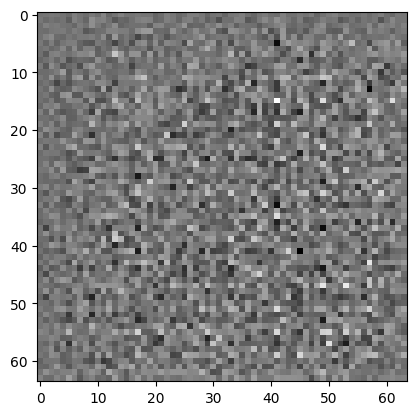

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,504 (10.43 MB)

 Trainable params: 2,700,352 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # First Conv2D layer:
    # - 64 filters of size 5x5
    # - Stride 2 downsamples input by factor of 2
    # - 'same' padding keeps output size consistent with stride
    # - Input shape is 64x64 RGB images (3 channels)
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))

    # LeakyReLU activation introduces non-linearity,
    # allowing small gradients when inputs are negative (alpha default 0.3)
    model.add(layers.LeakyReLU())

    # Dropout with rate 0.3 randomly sets 30% of inputs to zero during training,
    # helping to prevent overfitting
    model.add(layers.Dropout(0.3))

    # Second Conv2D layer:
    # - 128 filters of size 5x5
    # - Stride 2 further downsamples the feature map
    # - Padding same maintains spatial size appropriately
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))

    # Another LeakyReLU activation layer
    model.add(layers.LeakyReLU())

    # Dropout again for regularization
    model.add(layers.Dropout(0.3))

    # Flatten the 3D feature maps to a 1D vector to connect with Dense layer
    model.add(layers.Flatten())

    # Final Dense layer outputs a single logit (real/fake score)
    model.add(layers.Dense(1))

    return model


In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[4.1756954e-05]], shape=(1, 1), dtype=float32)


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)#Files are saved with the prefix like:./training_checkpoints/ckpt-1, ./training_checkpoints/ckpt-2, etc

In [ ]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 128
BATCH_SIZE = 128

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
#step is a batch
generator_losses = []
discriminator_losses = []
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)#will update paarmeters with it
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))#ab3talaha gradients and weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_loss_list = []
        disc_loss_list = []

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_list.append(gen_loss)
            disc_loss_list.append(disc_loss)

        # Save mean losses for the epoch
        generator_losses.append(np.mean(gen_loss_list))
        discriminator_losses.append(np.mean(disc_loss_list))

        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec, '
              f'Gen loss: {generator_losses[-1]:.4f}, Disc loss: {discriminator_losses[-1]:.4f}')


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
#step is a batch
generator_losses = []
discriminator_losses = []
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)#will update paarmeters with it
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))#ab3talaha gradients and weights
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Return the losses
    return gen_loss, disc_loss

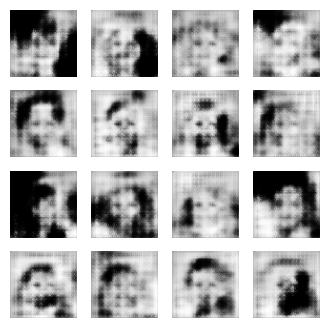

Time for epoch 1 is 161.23 sec, Gen loss: 2.1312, Disc loss: 0.6971


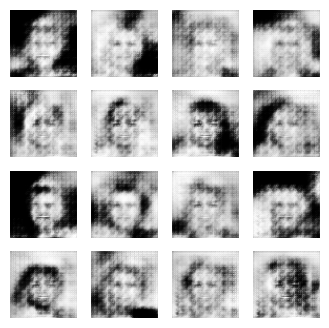

Time for epoch 2 is 155.65 sec, Gen loss: 1.4048, Disc loss: 0.8923


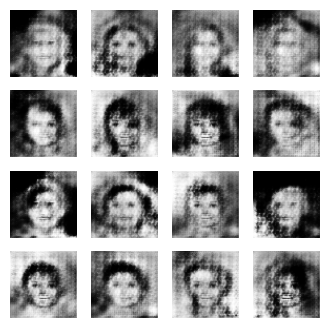

Time for epoch 3 is 155.32 sec, Gen loss: 1.6013, Disc loss: 0.8437


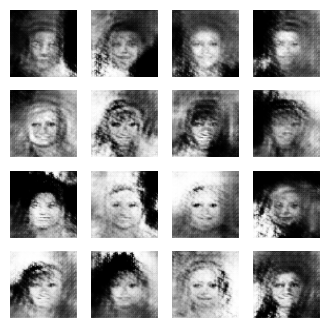

Time for epoch 4 is 155.55 sec, Gen loss: 1.6275, Disc loss: 0.8357


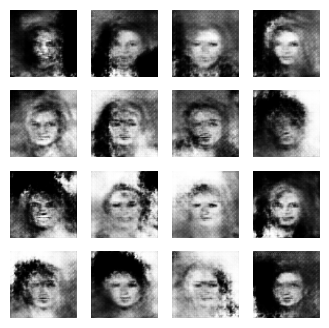

Time for epoch 5 is 155.55 sec, Gen loss: 1.6271, Disc loss: 0.8594


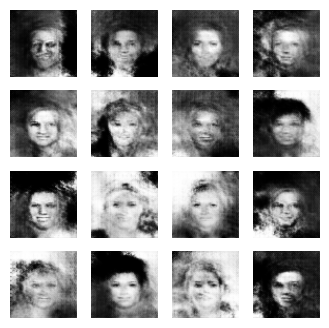

Time for epoch 6 is 155.48 sec, Gen loss: 1.7927, Disc loss: 0.8120


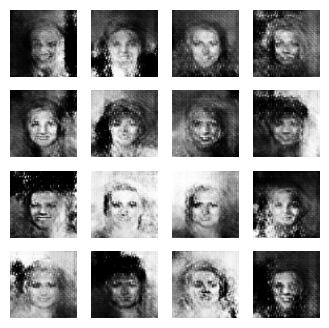

Time for epoch 7 is 155.82 sec, Gen loss: 1.8784, Disc loss: 0.7629


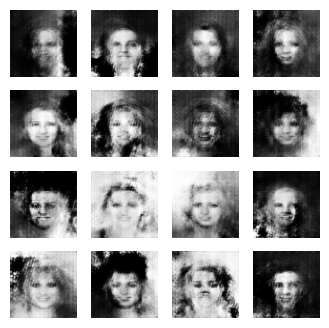

Time for epoch 8 is 155.42 sec, Gen loss: 1.9845, Disc loss: 0.7271


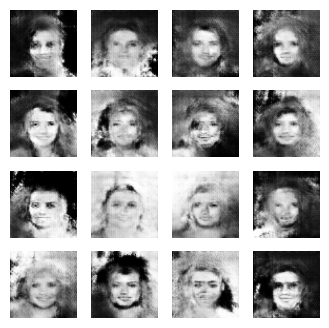

Time for epoch 9 is 155.41 sec, Gen loss: 2.0511, Disc loss: 0.7040


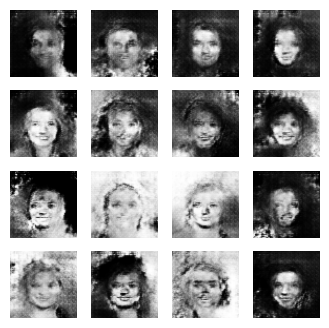

Time for epoch 10 is 155.88 sec, Gen loss: 2.0397, Disc loss: 0.7050


In [ ]:
train(dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#A checkpoint is a saved snapshot of your model's current weights and the state of optimizers during training.


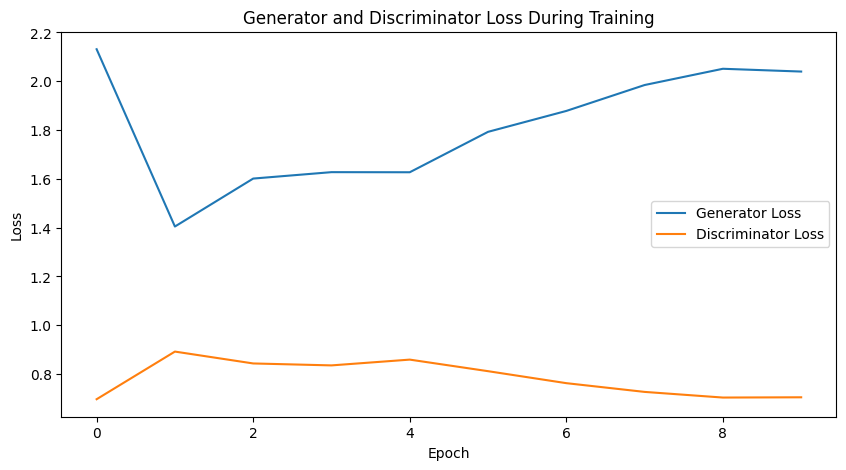

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Generator and Discriminator Loss During Training')
    plt.legend()
    plt.show()

# After training is done
plot_losses(generator_losses, discriminator_losses)


In [1]:
print("Final generated images after training:")
generate_and_save_images(generator, EPOCHS, seed)


Final generated images after training:


NameError: name 'generate_and_save_images' is not defined